some notes:
============

to install this thing:
---------------------
* create AMI on https://nervana.signin.aws.amazon.com/console
* sudo apt-get update
* sudo apt-get install git make python-pip python-dev libhdf5-dev
* sudo pip install virtualenv
* git clone https://github.com/NervanaSystems/neon.git
* cd neon; make; . .venv/bin/activate
* pip install ipython jupyter matplotlib
* ipython notebook --ip 0.0.0.0 --no-browser

and you are in business!

to connect to the notebook from outside:
* add custom TCP rule to open port 8888

Getting started with neon
=========================
This notebook is a tutorial for neon beginners. It helps you specify a small convNet model, and train it on packaged <a href=https://www.kaggle.com/c/cifar-10>Cifar10</a> data. It then shows you how to upload your own image, and classify it into the 10 categories:

airplane 
automobile 
bird 
cat 
deer 
dog 
frog 
horse 
ship 
truck

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3649/media/cifar-10.png">

At the end of this tutorial, you should be able to upload your own images and classify them into one of the 10 categories.


Setting up a model
==================
The pieces we need to set up a model are described in the <a href=http://neon.nervanasys.com/docs/latest/user_guide.html> user guide </a>:
* CIFAR10 dataset 
* layer configuration and a <a href=http://neon.nervanasys.com/docs/latest/user_guide.html#model> model </a>
* a compute <a href=http://neon.nervanasys.com/docs/latest/user_guide.html#backend-setup> backend </a>
* an optimizer

In [1]:
# We start by generating the backend:
from neon.backends import gen_backend
be = gen_backend(backend='gpu',             
                 batch_size=128)

# there is not much we can do with the backend right now, but if we
# print it, it should tell us that we have a CPU backend object
print be

Loading a dataset
-----------------
Loading and generating datasets is explained in our documentation at http://neon.nervanasys.com/docs/latest/datasets.html

In [2]:
# The dataset is supplied in canned form, and will be downloaded 
# from the web the first time you run this. It just returns numpy
# arrays with the pixel values, and class labels. 
from neon.data import load_cifar10
(X_train, y_train), (X_test, y_test), nclass = load_cifar10()

# to put the dataset into a format neon can understand, we create
# a DataIterator instance. This moves the data onto the compute
# device (e.g. GPU) and provides an iterator that returns training
# batches. 
from neon.data import DataIterator
train_set = DataIterator(X_train, y_train, nclass=nclass, lshape=(3, 32, 32))
test_set = DataIterator(X_test, y_test, nclass=nclass, lshape=(3, 32, 32))

Network Layers
--------------
Layer types are explained in http://neon.nervanasys.com/docs/latest/layers.html
It helps to make use of iPython tab completion to see available layers (e.g. from neon.layers import TAB) and to use the docstrings.

Layer types include things such as
* Convolution
* Bias
* Activation
* Pooling
* Batch Normalization
and for commonly used combinations neon provides shortcuts:
* Conv = Convolution + Bias + Activation
* Affine = Linear + Bias + Activation

for this network, we are going to use one Conv, one Pooling and one Affine layer. 

/Extra credit: The ELU nonlinearity. This is supposed to speed up learning and show how to extend neon with custom code./

In [26]:
# from neon.transforms.activation import Rectlin
# class ELU(Rectlin):
#     def __init__(self):
#         name = "ELU"
#         super(Rectlin, self).__init__(name)
#         self.alpha = 1

#     def __call__(self, x):
#         return x if self.be.greater(x, 0) else self.alpha * (self.be.exp(x)-1)

#     def bprop(self, x):
#         return 1 if self.be.greater(x, 0) else self.alpha * (self.be.exp(x)-1) + self.alpha    

In [86]:
# Now we create a model by assembling some layers
from neon.layers import Conv, Affine, Pooling
from neon.initializers import Uniform
from neon.transforms.activation import Rectlin, Softmax
init_uni = Uniform(low=-0.1, high=0.1)
layers = [Conv(fshape=(5,5,16), init=init_uni, activation=Rectlin()),
          Pooling(fshape=2, strides=2),
          Conv(fshape=(5,5,32), init=init_uni, activation=Rectlin()),
          Pooling(fshape=2, strides=2),
          Affine(nout=500, init=init_uni, activation=Rectlin()),
          Affine(nout=10, init=init_uni, activation=Softmax())]

# set up model
from neon.models import Model
model = Model(layers)



Cost function
--------------
Next we need a cost function to evaluate the output of the network. The cost function compares network outputs with ground truth labels, and produces and error that we can backpropagate through the layers of the network.

Common cost functions are
* Cross Entropy
* Sum of squares difference

For our binary classification task, we use crossentropy

In [87]:
# setting up the cost function
from neon.layers import GeneralizedCost
from neon.transforms import CrossEntropyMulti
cost = GeneralizedCost(costfunc=CrossEntropyMulti())

Optimizer
---------
We now have a cost function that we want to minimize, typically by following 
the negative gradient of the cost. This is called gradient descent. We do this
iteratively over small batches of the data set, making it stochastic gradient 
decesent (SGD). There are other optimzers such as
* RMSProp
* AdaDelta

that are supported in neon, but often simple gradient descent works well.

In [88]:
# set up optimizer
from neon.optimizers import GradientDescentMomentum, RMSProp
optimizer = GradientDescentMomentum(learning_rate=0.005, momentum_coef=0.9)
#optimizer = RMSProp()

Callbacks
---------
To provide feedback while the model is training, neon lets the user specify a set of callbacks that get evaluated at the end of every iteration (minibatch) or pass through the dataset (epoch). Callbacks include evaluating the model on a validation set or computing missclassification percentage. There are also callbacks for saving to disk and for generating visualizations. Here we will set up a progress bar to monitor training.

In [89]:
# set up callbacks. By default sets up a progress bar
from neon.callbacks.callbacks import Callbacks
callbacks = Callbacks(model, train_set)

Training the model
------------------
Now all the pieces are in place to run the network. We use the fit function and pass it a dataset, cost, optmizer, and the callbacks we set up.

In [90]:
# And  run the model
model.fit(dataset=train_set,
          cost=cost,
          optimizer=optimizer,
          num_epochs=40,
          callbacks=callbacks)

Epoch 0   [Train |████████████████████|  391/391  batches, 1.59 cost, 0.96s]
Epoch 1   [Train |████████████████████|  391/391  batches, 1.40 cost, 0.99s]
Epoch 2   [Train |████████████████████|  390/390  batches, 1.31 cost, 0.99s]
Epoch 3   [Train |████████████████████|  391/391  batches, 1.21 cost, 0.99s]
Epoch 4   [Train |████████████████████|  390/390  batches, 1.15 cost, 0.98s]
Epoch 5   [Train |████████████████████|  391/391  batches, 1.07 cost, 0.99s]
Epoch 6   [Train |████████████████████|  391/391  batches, 1.01 cost, 0.99s]
Epoch 7   [Train |████████████████████|  390/390  batches, 0.98 cost, 0.99s]
Epoch 8   [Train |████████████████████|  391/391  batches, 0.93 cost, 0.99s]
Epoch 9   [Train |████████████████████|  391/391  batches, 0.89 cost, 0.99s]
Epoch 10  [Train |████████████████████|  390/390  batches, 0.84 cost, 0.98s]
Epoch 11  [Train |████████████████████|  391/391  batches, 0.82 cost, 0.99s]
Epoch 12  [Train |████████████████████|  390/390  batches, 0.78 cost, 0.99s]

Congrats, if you made it this far you have trained a convolutional network in neon.

Evaluating the model
--------------------
We can now compute the misclassification on the test set to see how well we did.

In [91]:
# Check the performance on the supplied test set
from neon.transforms import Misclassification
print 'Misclassification error = %.1f%%' % (model.eval(test_set, metric=Misclassification())*100)

Misclassification error = 40.4%


By tweaking some of the hyperparameters (number of layers, adding dropout...) we can improve the performance.

This was quite a lot of code! Generally, to set up a new model from scratch it is best to follow one of the examples from the neon/examples directory. It's easy to mix and match parts!





Visualizations
--------------
But first, lets look at whats going on inside the model. For this we will use matplotlib to make some visualizations

shape (75, 16)
[[ 0.28793609 -0.06150856  0.11460879 ..., -0.08780234  0.35006201
  -0.24346967]
 [ 0.31608564  0.26100114 -0.15777992 ..., -0.12366543  0.04897519
  -0.19653422]
 [-0.10796933  0.38127381 -0.32522649 ..., -0.11146627 -0.27418122
  -0.20478141]
 ..., 
 [ 0.2227913   0.35168371  0.59361702 ...,  0.14048272  0.46139881
   0.06821094]
 [-0.06844849  0.17166287  0.55679786 ..., -0.0227278   0.08557089
   0.1152233 ]
 [-0.14400844 -0.03177495  0.40571338 ..., -0.04805142 -0.23483859
   0.06853524]]
min -1.46263
[[ 1.75056207  1.40111744  1.57723475 ...,  1.37482369  1.81268799
   1.21915627]
 [ 1.77871156  1.72362709  1.30484605 ...,  1.33896053  1.51160121
   1.26609182]
 [ 1.3546567   1.84389973  1.13739944 ...,  1.35115969  1.18844473
   1.25784457]
 ..., 
 [ 1.68541729  1.81430972  2.05624294 ...,  1.60310864  1.92402482
   1.53083694]
 [ 1.39417744  1.63428879  2.01942396 ...,  1.43989813  1.54819691
   1.57784927]
 [ 1.31861758  1.43085098  1.8683393  ...,  1.41457462 

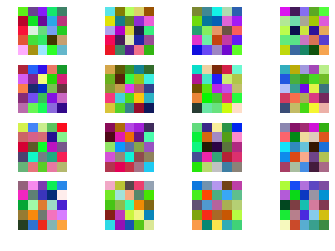

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
weights = model.layers.layers[0].W.get()
print "shape", weights.shape
print weights
print "min", weights.min()
weights = weights - weights.min()
print weights
print "max", weights.max()
weights = weights / weights.max()
print weights
weights = 255. * weights
print weights
for feature in range(16):
    f_map = weights[:,feature].reshape(3,5,5).transpose((1,2,0))

    f_map = weights[:,feature].reshape(5,5,3)

    plt.subplot(4,4,feature+1)
    plt.imshow(f_map, interpolation='nearest')
    plt.axis('off')

Inference
=========
Now we want to grab a new image from the internet and classify it through our network!

(-0.5, 31.5, 31.5, -0.5)

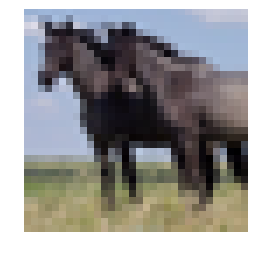

In [18]:
# an image of a from I found on Wikipedia
img_source = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Atelopus_zeteki1.jpg/440px-Atelopus_zeteki1.jpg"
img_source = "https://upload.wikimedia.org/wikipedia/commons/d/de/Nokota_Horses_cropped.jpg"
# download the image
import urllib
urllib.urlretrieve(img_source, filename="frog.jpg")

# crop and resize to 32x32
from PIL import Image

img = Image.open('frog.jpg')
crop = img.crop((0,0,min(img.size),min(img.size)))
crop.thumbnail((32, 32))
plt.imshow(crop, interpolation="nearest")  # crop or img
plt.axis('off')



Make a new backend with a batch size of 1 for inference

In [15]:
# create a minibatch with the new image 
import numpy as np
x_new = np.zeros((128,3072), dtype=np.float32)
x_new[0] = np.asarray(crop, dtype=np.float32).flatten().reshape(1,3072)/ 255

inference_set = DataIterator(x_new, None, nclass=nclass, lshape=(3, 32, 32))

In [16]:
classes =["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
out = model.get_outputs(inference_set)
classes[out[0].argmax()]


'cat'